<a href="https://colab.research.google.com/github/jsm-UOC/tensorflowCourse/blob/main/FeatureExtractionANNCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF: Feature Extraction


In [ ]:
!nvidia-smi

Wed May  3 06:30:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Become one with the data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-05-03 06:30:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   146MB/s    in 1.1s    

2023-05-03 06:30:35 (146 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 in 10_food_classes_10_percent/train/pizza
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_f

## Create data loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10, trainable=False):

  feature_extrator_layer = hub.KerasLayer(model_url,
                                          trainable=trainable,
                                          name="feature_extrator_layer",
                                          input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extrator_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Resnet Model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes, trainable=False)

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extrator_layer (Ker  (None, 2048)             23564800  
 asLayer)                                                        
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="resnet50v")])

Saving Tensorboard log files to: tensorflow_hub/resnet50v/20230503-073823
Epoch 1/5
24/24 [==============================] - 23s 767ms/step - loss: 2.1089 - accuracy: 0.2987 - val_loss: 1.2968 - val_accuracy: 0.5740
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9731 - accuracy: 0.7173 - val_loss: 0.8733 - val_accuracy: 0.7264
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6497 - accuracy: 0.8213 - val_loss: 0.7665 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 17s 723ms/step - loss: 0.5013 - accuracy: 0.8800 - val_loss: 0.7066 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 18s 748ms/step - loss: 0.3970 - accuracy: 0.9173 - val_loss: 0.6760 - val_accuracy: 0.7824


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="validation_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

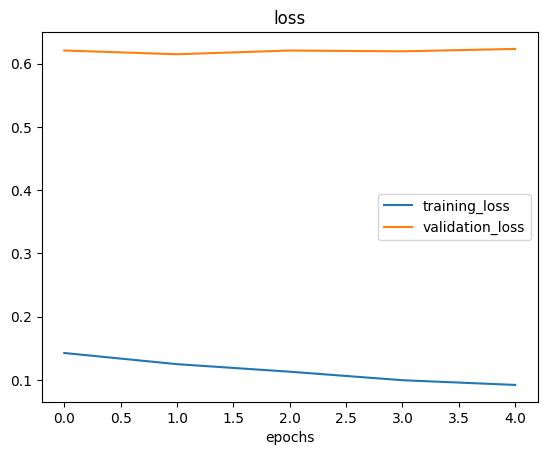

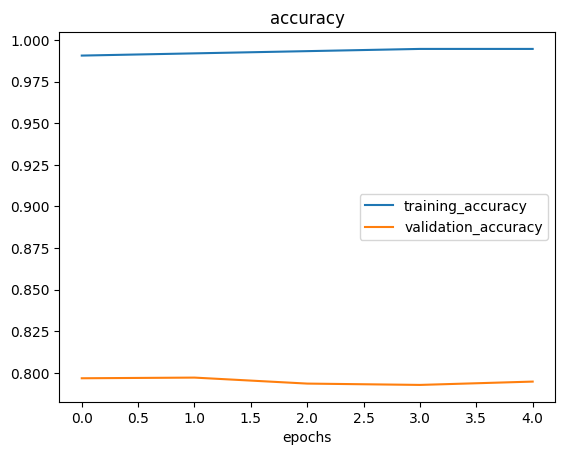

In [ ]:
plot_loss_curves(resnet_history)

### Efficient Model

In [ ]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extrator_layer (Ker  (None, 1280)             4049564   
 asLayer)                                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
from wandb.keras import WandbCallback
efficientnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="efficientb0"), WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Saving Tensorboard log files to: tensorflow_hub/efficientb0/20230503-082244
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.9373

wandb: Adding directory to artifact (/content/wandb/run-20230503_081232-0q2vh1vx/files/model-best)... Done. 0.3s


24/24 [==============================] - 27s 1s/step - loss: 0.3258 - accuracy: 0.9373 - val_loss: 0.6594 - val_accuracy: 0.7876
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.9587

wandb: Adding directory to artifact (/content/wandb/run-20230503_081232-0q2vh1vx/files/model-best)... Done. 0.3s


24/24 [==============================] - 26s 1s/step - loss: 0.2719 - accuracy: 0.9587 - val_loss: 0.6437 - val_accuracy: 0.7912
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9680

wandb: Adding directory to artifact (/content/wandb/run-20230503_081232-0q2vh1vx/files/model-best)... Done. 0.3s


24/24 [==============================] - 28s 1s/step - loss: 0.2287 - accuracy: 0.9680 - val_loss: 0.6402 - val_accuracy: 0.7876
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9720

wandb: Adding directory to artifact (/content/wandb/run-20230503_081232-0q2vh1vx/files/model-best)... Done. 0.3s


24/24 [==============================] - 27s 1s/step - loss: 0.1967 - accuracy: 0.9720 - val_loss: 0.6330 - val_accuracy: 0.7880
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9840

wandb: Adding directory to artifact (/content/wandb/run-20230503_081232-0q2vh1vx/files/model-best)... Done. 0.3s


24/24 [==============================] - 32s 1s/step - loss: 0.1715 - accuracy: 0.9840 - val_loss: 0.6306 - val_accuracy: 0.7880


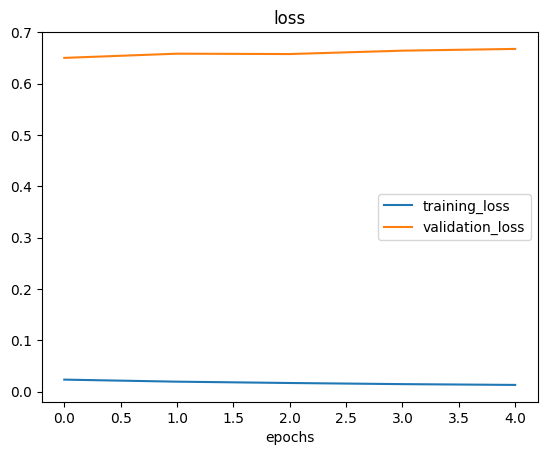

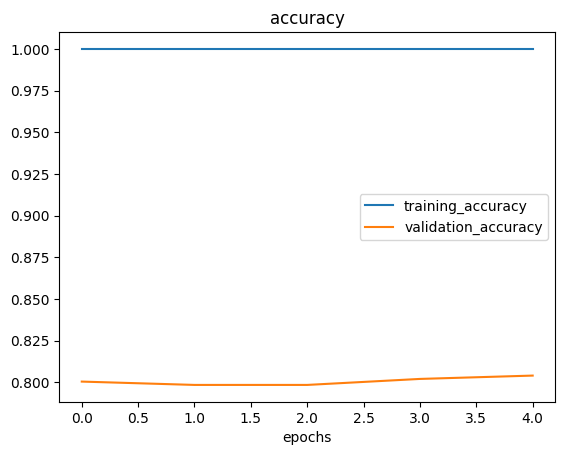

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.layers[0].weights

## Compairing models

In [ ]:
!tensorboard dev upload --logdir /content/tensorflow_hub/ \
  --name "EfficentNet vs. ResNet"\
  --description "NONE"\
  --one_shot

2023-05-03 07:49:49.233934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/GkpU30QkRuG0oxGCpUzOww/

[2023-05-03T07:49:51] Started scanning logdir.
[2023-05-03T07:49:59] Total uploaded: 186 scalars, 0 tensors, 8 binary objects (14.9 MB)
[2023-05-03T07:49:59] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/GkpU30QkRuG0oxGCpUzOww/


In [ ]:
!tensorboard dev list

2023-05-03 07:52:14.183894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/GkpU30QkRuG0oxGCpUzOww/
	Name                 EfficentNet vs. ResNet
	Description          NONE
	Id                   GkpU30QkRuG0oxGCpUzOww
	Created              2023-05-03 07:49:51 (2 minutes ago)
	Updated              2023-05-03 07:49:59 (2 minutes ago)
	Runs                 15
	Tags                 5
	Scalars              186
	Tensor bytes         0
	Binary object bytes  15584433
https://tensorboard.dev/experiment/wL83jhq2RnGj3Wj7vFXIVg/
	Name                 EfficentNet vs. ResNet
	Description          NONE
	Id                   wL83jhq2RnGj3Wj7vFXIVg
	Created              2023-05-03 07:48:10 (4 minutes ago)
	Updated              2023-05-03 07:48:18 (3 minutes ago)
	Runs                 15
	Tags                 5
	Scalars              186
	Tensor bytes         0
	Binary object bytes  15584433
https://tensorboard.dev/experime

In [ ]:
import wandb
wandb.login()
wandb.init(project='gpt3')


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jorgesm97. Use `wandb login --relogin` to force relogin


TypeError: ignored

NameError: ignored

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
